In [1]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import calendar
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os

os.chdir(r'C:\Users\jf79\Repos\REAP-Analytics')
import myfuncs.myfuncs as mf
import repofuncs.reapmonthlyfuncs as rmf

import warnings
warnings.filterwarnings('ignore')

path_to_data = r"C:\Users\jf79\OneDrive - Office Shared Service\Sharepoint Links\BI - Corporate - Documents\REAP\1. REAP Monthly Report 2025\Granicus"
mf.read_directory(directory=path_to_data)
os.chdir(path_to_data)
lookup_data = pd.read_excel("Granicus Process List.xlsx")
granicus_case_data = mf.query_data(schema='granicus', data='GranicusRedshift_Cases')
granicus_process_data = mf.query_data(schema='granicus', data='GranicusRedshift_Processes')

Directory being read is: C:\Users\jf79\OneDrive - Office Shared Service\Sharepoint Links\BI - Corporate - Documents\REAP\1. REAP Monthly Report 2025\Granicus
DataFrame: files
Number of records: 2 | Number of fields: 1
Number of unique duplicate records: 0 | Total number of duplicate records: 0


,File Names
0,Granicus E-Process Report.xlsx
1,Granicus Process List.xlsx


Successfully imported GranicusRedshift_Cases
Successfully imported GranicusRedshift_Processes


In [2]:
month_order = [
    'April','May','June','July','August','September','October','November',
    'December','January','February','March']

date_dic = rmf.obtain_relevant_dates(granicus_case_data, 'date_completed')

In [3]:
granicus_case_data['date_completed'] = pd.to_datetime(granicus_case_data['date_completed'])
granicus_case_data = granicus_case_data[
    (granicus_case_data['date_completed'].isna() == False) &
    (granicus_case_data['date_completed'] >= pd.to_datetime("2022-04-01", format="%Y-%m-%d"))
]
granicus_case_data['month'] = granicus_case_data['date_completed'].dt.month.apply(lambda m: calendar.month_name[m])
granicus_case_data['tax_year'] = granicus_case_data['date_completed'].apply(
    lambda x: f'{str(x.year)[-2:]}-{str(x.year+1)[-2:]}'
    if x.month >= 4 
    else f'{str(x.year-1)[-2:]}-{str(x.year)[-2:]}'
)

forms_data = pd.merge(
    granicus_case_data, granicus_process_data,
    how='left', on='process_id'
)

forms_data = pd.merge(
    forms_data, lookup_data,
    how='left', on='process_id',
    suffixes=['','_drop']
)

forms_data = forms_data[forms_data['process_name_drop'].isna() == False]

forms_data = forms_data[forms_data['date_completed'] < pd.to_datetime(date_dic['prev_full_month'], format='%Y-%m') + DateOffset(months=1)]

forms_data = forms_data.groupby(['tax_year','month'])['case_id'].count().reset_index()

forms_data = forms_data.pivot(
    index='month',
    columns='tax_year',
    values='case_id'
).reindex(month_order).fillna(0)

mf.display(forms_data)

DataFrame: forms_data
Number of records: 12 | Number of fields: 4
Number of unique duplicate records: 0 | Total number of duplicate records: 0


tax_year,22-23,23-24,24-25,25-26
month,,,,
April,7380.0,10093.0,11472.0,9019.0
May,7177.0,10050.0,11304.0,8087.0
June,6472.0,10698.0,10068.0,7974.0
July,7274.0,11172.0,10855.0,8857.0
August,7527.0,20062.0,9904.0,8655.0
September,7300.0,15951.0,10712.0,0.0
October,7207.0,12252.0,9683.0,0.0
November,7827.0,11147.0,8549.0,0.0
December,7790.0,7959.0,7551.0,0.0


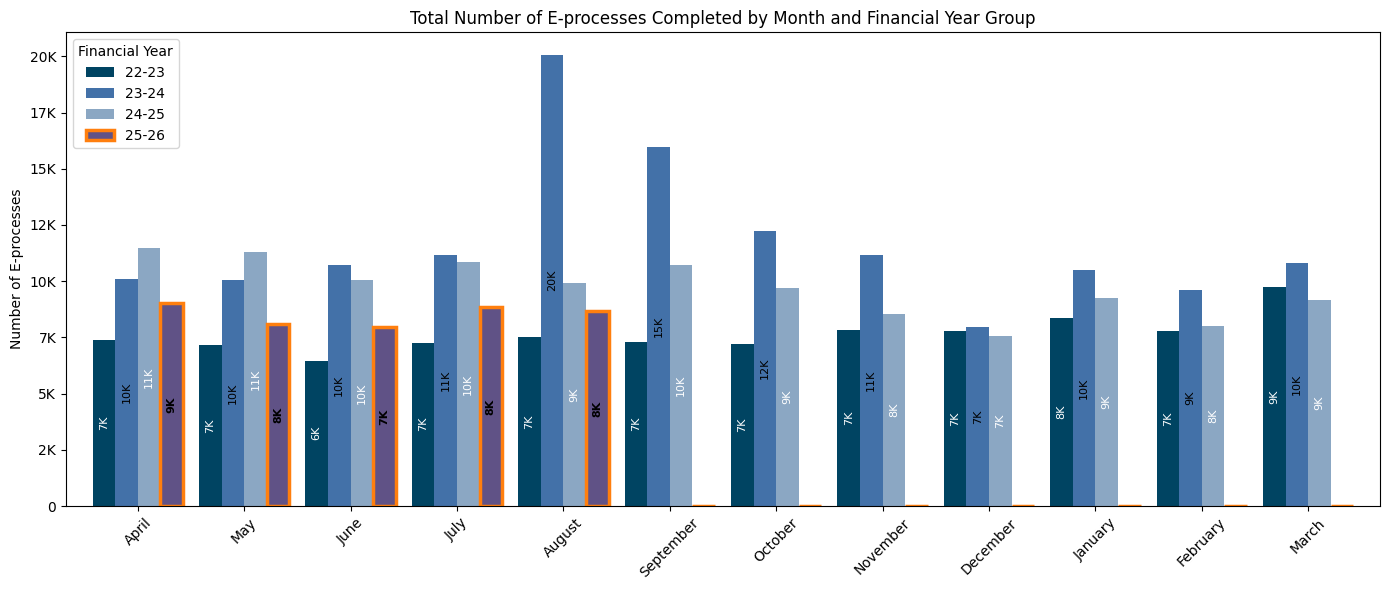

In [4]:
# Base colors
base_colors = ["#004c6d", "#4a7ebb", "#9bbad9", "#6b5b95"]
 
# Dynamically generate colors for however many year groups exist
n_years = len(forms_data.columns)
colors = []
for i in range(n_years):
    base = mcolors.to_rgb(base_colors[i % len(base_colors)])
    factor = 0.9 + 0.2 * (i // len(base_colors))  # lighten/darken cycles
    colors.append(tuple(np.clip([c * factor for c in base], 0, 1)))
 
# Plot grouped bar chart
ax = forms_data.plot(kind='bar', figsize=(14,6), width=0.85, color=colors)
 
# Highlight the last year group with a standout outline
highlight_edge = "#ff7f0e"  # bright orange outline
for patch in ax.containers[-1]:  # last year group bars
    patch.set_edgecolor(highlight_edge)
    patch.set_linewidth(2.5)
 
# Alternate label colors (white/black)
label_colors = ["white" if i % 2 == 0 else "black" for i in range(n_years)]
 
# Add labels in the center of bars, omit zeros
for idx, container in enumerate(ax.containers):
    labels = []
    for v in container.datavalues:
        if v == 0 or np.isnan(v):
            labels.append("")
        elif v >= 1000:
            labels.append(f"{int(v/1000)}K")
        else:
            labels.append(str(int(v)))
    # Bold labels only for the last year group
    weight_style = "bold" if idx == n_years - 1 else "normal"
    ax.bar_label(container, labels=labels, label_type='center',
                 fontsize=8, color=label_colors[idx],
                 weight=weight_style, rotation=90)
 
# Format y-axis labels with K
ax.set_yticklabels([f"{int(y/1000)}K" if y >= 1000 else int(y) for y in ax.get_yticks()])
ax.set_xlabel("")
 
plt.ylabel('Number of E-processes')
plt.title('Total Number of E-processes Completed by Month and Financial Year Group')
plt.xticks(rotation=45)
plt.legend(title='Financial Year', loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
columns_to_drop = [
    'date_due_warn','date_due','citizen_id'
]
granicus_case_data.drop(columns=columns_to_drop, inplace=True)

In [ ]:
report_data = pd.merge(
    granicus_case_data, granicus_process_data,
    how='left', on='process_id'
)

report_data['month_of_form'] = report_data['date_completed'].dt.strftime("%Y-%m")

report_data = report_data.groupby(['month_of_form', 'process_name','process_id'])['case_id'].count().reset_index().sort_values(by=['month_of_form', 'case_id'], ascending=False)
report_data = report_data[report_data['month_of_form'] == date_dic['prev_full_month']]

report_data = pd.merge(
    report_data, lookup_data,
    how='left', on='process_id',
    suffixes=['','_drop']
)

report_data = report_data[report_data['process_name_drop'].isna() == False]
report_data.rename(
    columns={
        'process_name':'E-Process',
        'case_id': date_dic['month_year']
    },
    inplace=True
)
report_data.drop(
    columns=['month_of_form','process_id','process_name_drop'],
    inplace=True
)

report_data[r'% Cummulative Total'] = report_data[date_dic['month_year']].cumsum() / report_data[date_dic['month_year']].sum()

print(f'Number of Published Forms: {len(report_data)}')

report_data = report_data[report_data[r'% Cummulative Total'] <= 0.9]
mf.display(report_data.reset_index(drop='index'))

Number of Published Forms: 89
Number of records: 25 | Number of fields: 3
Number of unique duplicate records: 0 | Total number of duplicate records: 0


,E-Process,Aug-2025,% Cummulative Total
0,Council tax moving in moving out,2269,0.262161
1,Contact parking permits,1163,0.396534
2,Bulky waste collection,607,0.466667
3,Housing advice,594,0.535298
4,Apply for a parking suspension,445,0.586713
5,"Smart sacks, order top-up",293,0.620566
6,Housing repairs reporting form,265,0.651184
7,Report a problem,207,0.675101
8,Council tax refund request,196,0.697747
9,Garages - apply for a garage,184,0.719006


In [ ]:
mf.export_file(
    report_data,
    directory = path_to_data,
    df_name = 'Granicus E-Process Report',
    file_type='xlsx',
    sheet_name='main'
)

Exporting Granicus E-Process Report to XLSX...
@ C:\Users\jf79\OneDrive - Office Shared Service\Sharepoint Links\BI - Corporate - Documents\REAP\1. REAP Monthly Report 2025\Granicus\Granicus E-Process Report.xlsx

Successfully exported Granicus E-Process Report to XLSX
